In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def plot_cm(gt,pred,le):
    cm = confusion_matrix(gt, pred, labels=le.classes_)
    fig = plt.figure(figsize=(6, 5), dpi=120)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(values_format="d")
    plt.title("ROI-level Confusion Matrix (OOF)")
    plt.tight_layout()
    plt.show()
def pr_table(y_true, y_pred, class_names):
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )
    return pd.DataFrame({
        "class": class_names,
        "precision": p,
        "recall": r,
        "f1": f1,
        "support": sup
    })

def plot_pr_grouped(df_pr, title=None, ylim=(0,1)):
    idx = np.arange(len(df_pr))
    width = 0.38

    fig, ax = plt.subplots(figsize=(8, 3.8), dpi=120)
    ax.bar(idx - width/2, df_pr["precision"].values, width, label="Precision")
    ax.bar(idx + width/2, df_pr["recall"].values,    width, label="Recall")
    ax.set_xticks(idx)
    ax.set_xticklabels(df_pr["class"].values, rotation=45, ha="right")
    ax.set_ylim(*ylim)
    ax.set_ylabel("Score")
    if title: ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()
# # Simple bar plots for precision/recall
# for metric in ["precision","recall"]:
#     plt.figure(figsize=(7,3), dpi=120)
#     ax = per_class[metric].plot(kind="bar")
#     plt.ylabel(metric.capitalize())
#     plt.xlabel("Class")
#     plt.title(f"Per-class {metric.capitalize()} (OOF)")
#     plt.xticks(rotation=45, ha="right")
#     plt.tight_layout()
#     plt.show()


0.34891141141141135
0.5353535353535354
0.5353535353535354
0.7372998023122447


<Figure size 720x600 with 0 Axes>

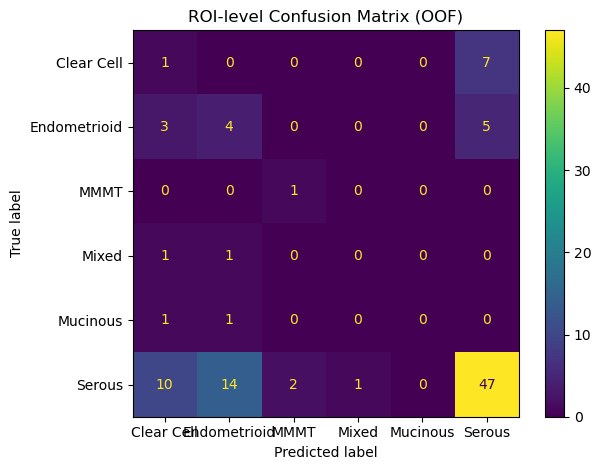

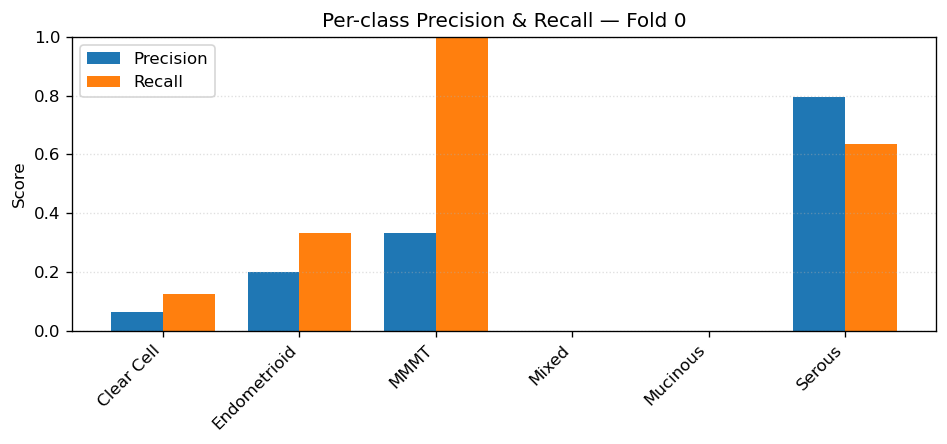

0.21369583869583866
0.6224489795918368
0.6224489795918368
0.6948886997736196


<Figure size 720x600 with 0 Axes>

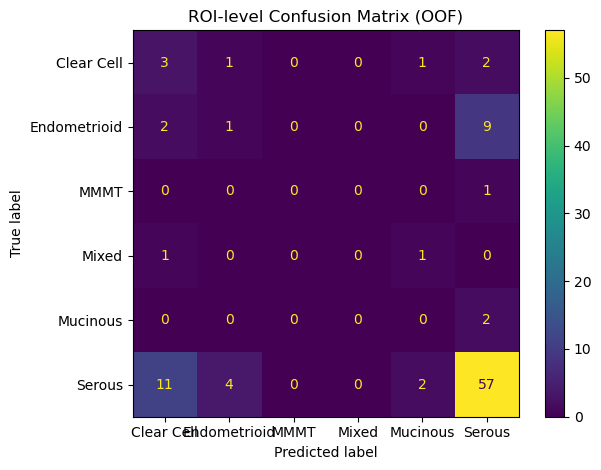

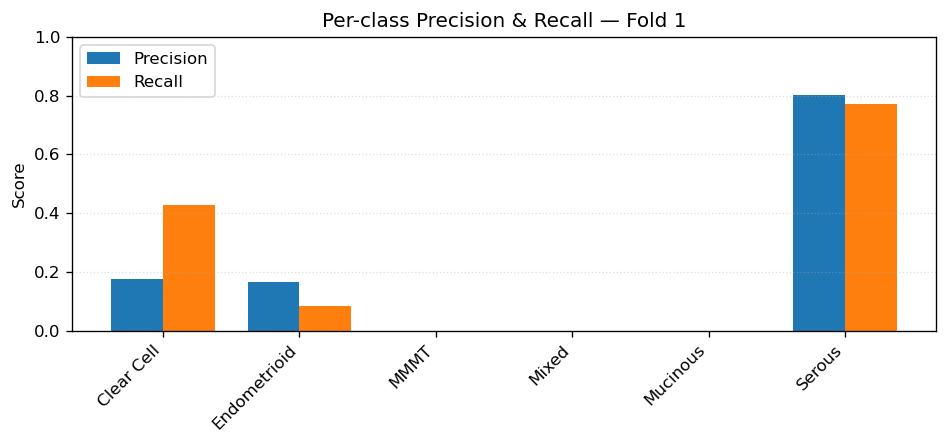

0.13013698630136986
0.5816326530612245
0.5816326530612245
0.6397805806314553


<Figure size 720x600 with 0 Axes>

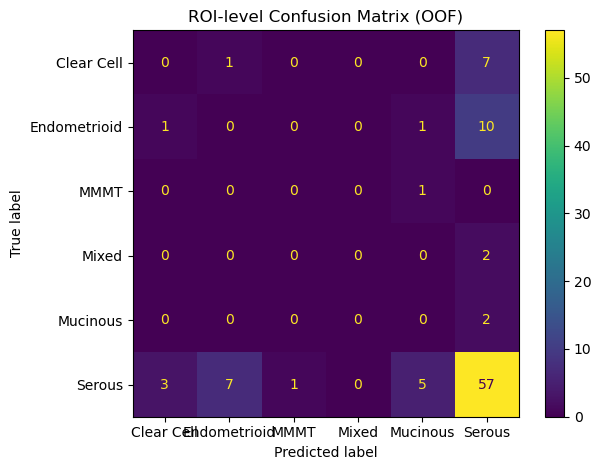

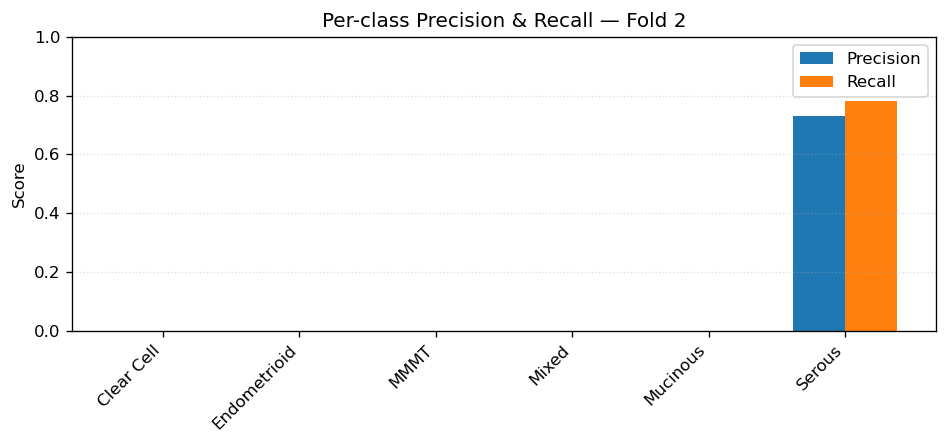

In [26]:
# --- Reproduce CV folds, GT/preds, and plots ---
from pathlib import Path
import pickle, yaml
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,balanced_accuracy_score,accuracy_score, recall_score,
    roc_auc_score
)
import matplotlib.pyplot as plt

# 1) POINT THIS TO YOUR run's --outdir
RUN_DIR = Path("/projects/wangc/m344313/OVTMA_project/output/fov297_fastrp_none")
EVAL_DIR = RUN_DIR / "evaluate" / "roi_supervised_best/roc_auc"

# 2) Load saved ROI embedding, ROI order, trained fold classifiers
E = loadmat(str(EVAL_DIR / "roi_embedding.mat"))["E"]           # (n_roi, d)
group_ids = pickle.load(open(EVAL_DIR / "group_ids.pkl", "rb")) # len n_roi, ROI keys aligned to rows of E
clf_list  = pickle.load(open(EVAL_DIR / "best_clf_list.pkl", "rb"))

# 3) Load labels & diagnostics (to match encodings/splits)
df = pd.read_csv(RUN_DIR / "dataframes" / "df.csv")
diag = yaml.safe_load(open(EVAL_DIR / "best_roi_supervision.yaml"))["diagnostics"]
classes_str = diag["classes"]                     # label names in the fit
n_splits_eff = int(diag["n_splits_effective"])

# ROI-level labels in the embedding order
roi_lab = (pd.DataFrame({"ROI": group_ids})
           .merge(df[["ROI","roi_label"]].drop_duplicates(), on="ROI", how="left"))
assert not roi_lab["roi_label"].isna().any(), "Missing ROI labels."

# Use the same label mapping as training (LabelEncoder equivalent)
# Ensure order matches classes_str from training
le = LabelEncoder(); le.classes_ = np.array(classes_str, dtype=object)
y = le.transform(roi_lab["roi_label"].values)

# Optional grouping (if present in df)
groups = None
use_groups = False
if "Subject" in df.columns:
    gmap = df[["ROI","Subject"]].drop_duplicates()
    groups = pd.DataFrame({"ROI": group_ids}).merge(gmap, on="ROI", how="left")["Subject"].values
    # Heuristic: if unique groups >= n_splits and matches clf_count, use GroupKFold
    use_groups = pd.Series(groups).notna().all() and pd.Series(groups).nunique() >= n_splits_eff

# 4) Rebuild the splitter exactly like training
if use_groups:
    splitter = GroupKFold(n_splits=n_splits_eff)
    split_iter = list(splitter.split(E, y, groups=groups))
else:
    # Training used shuffle=True, random_state=cfg.random_state (defaults to 42)
    try:
        run_cfg = yaml.safe_load(open(RUN_DIR / "config" / "resolved_config.yaml"))["roi_supervision"]
        rs = int(run_cfg.get("random_state", 42))
    except Exception:
        rs = 42
    splitter = StratifiedKFold(n_splits=n_splits_eff, shuffle=True, random_state=rs)
    split_iter = list(splitter.split(E, y))

assert len(split_iter) == len(clf_list), "Mismatch: fold count vs saved classifiers."

# 5) Collect per-fold predictions
oof_rows = []
for fold_idx, ((tr, va), clf) in enumerate(zip(split_iter, clf_list)):
    y_true = y[va]
    y_pred = clf.predict(E[va])
    proba  = clf.predict_proba(E[va])  # columns correspond to le.classes_
    for i, idx in enumerate(va):
        row = {
            "fold": fold_idx,
            "ROI": group_ids[idx],
            "y_true": le.classes_[y_true[i]],
            "y_pred": le.classes_[y_pred[i]],
        }
        # add per-class probabilities (nice to have)
        for ci, cname in enumerate(le.classes_):
            row[f"proba_{cname}"] = float(proba[i, ci])
        oof_rows.append(row)
oof = pd.DataFrame(oof_rows)
class_to_idx = {c:i for i,c in enumerate(le.classes_)}


for fold_id, g in oof.groupby("fold", sort=True):
    print(balanced_accuracy_score(g["y_true"], g["y_pred"]))
    print(accuracy_score(g["y_true"], g["y_pred"]))
    print(recall_score(g["y_true"], g["y_pred"],average="weighted"))
    proba = g[['proba_Clear Cell',
       'proba_Endometrioid', 'proba_MMMT', 'proba_Mixed', 'proba_Mucinous',
       'proba_Serous']].values
    print(roc_auc_score(g["y_true"], proba,multi_class="ovr", average="macro"))
    plot_cm(g["y_true"], g["y_pred"], le)
    y_true_idx_f = g["y_true"].map(class_to_idx).values
    y_pred_idx_f = g["y_pred"].map(class_to_idx).values
    pr_f = pr_table(y_true_idx_f, y_pred_idx_f, class_names=le.classes_)

    plot_pr_grouped(pr_f, title=f"Per-class Precision & Recall — Fold {fold_id}", ylim=(0,1))


## interprete

In [27]:
# --- Attribution of predictions to ROI-embedding dimensions ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ATTR_DIR = EVAL_DIR / "attribution"
ATTR_DIR.mkdir(parents=True, exist_ok=True)

def _extract_scaler_lr(pipeline):
    """Assumes make_pipeline(StandardScaler, LogisticRegression)."""
    # pipeline.steps = [('standardscaler', Scaler), ('logisticregression', LR)]
    scaler = None
    lr = None
    for name, step in pipeline.steps:
        from sklearn.preprocessing import StandardScaler
        from sklearn.linear_model import LogisticRegression
        if isinstance(step, StandardScaler):
            scaler = step
        elif isinstance(step, LogisticRegression):
            lr = step
    assert scaler is not None and lr is not None, "Unexpected pipeline layout."
    return scaler, lr

def ig_shap_logit_contrib(X, scaler, lr):
    """
    Exact per-feature contributions to the class logits.
    Returns: contribs (n_samples, n_classes, n_features), logits (n_samples, n_classes)
    """
    # standardize using scaler
    Z = (X - scaler.mean_) / scaler.scale_
    W = lr.coef_                  # (C, d)
    b = lr.intercept_             # (C,) for multinomial
    logits = Z @ W.T + b          # (n, C)
    # per-feature contributions (n, C, d): multiply standardized X by class weights
    contribs = np.einsum('nd,cd->ncd', Z, W)
    return contribs, logits

# Collect per-fold attributions on the validation split (OOF-style)
attr_rows = []
per_fold_topk_figs = []
k_top = 15  # change if you want more/less features in the summaries

for fold_idx, ((tr_idx, va_idx), clf) in enumerate(zip(split_iter, clf_list)):
    scaler, lr = _extract_scaler_lr(clf)

    X_va = E[va_idx]                          # ROI embeddings for this fold's val split
    y_true_va = y[va_idx]
    roi_ids_va = [group_ids[i] for i in va_idx]
    proba_va = clf.predict_proba(X_va)        # (n_va, C)
    y_pred_va = np.argmax(proba_va, axis=1)

    contribs, logits = ig_shap_logit_contrib(X_va, scaler, lr)  # (n_va, C, d), (n_va, C)
    n_va, C, d = contribs.shape
    class_names = list(le.classes_)

    # Long-form rows
    for i in range(n_va):
        for c in range(C):
            # store vector once per class (can be large; feel free to thin if needed)
            row_base = {
                "fold": fold_idx,
                "ROI": roi_ids_va[i],
                "y_true": class_names[y_true_va[i]],
                "y_pred": class_names[y_pred_va[i]],
                "class": class_names[c],
                "logit": float(logits[i, c]),
                "proba": float(proba_va[i, c]),
            }
            # Per-dimension contributions
            for j in range(d):
                attr_rows.append({
                    **row_base,
                    "feat_idx": j,
                    "contrib": float(contribs[i, c, j]),
                })

    # --- Quick class-wise top-|contrib| summary for this fold ---
    # mean absolute contribution across validation samples
    mean_abs = np.mean(np.abs(contribs), axis=0)  # (C, d)
    fig, axes = plt.subplots(1, C, figsize=(3.2*C, 3.8), sharey=False)
    if C == 1:
        axes = [axes]
    for c in range(C):
        vals = mean_abs[c]
        top_idx = np.argsort(vals)[::-1][:k_top]
        axes[c].barh([f"d{j}" for j in top_idx[::-1]], vals[top_idx][::-1])
        axes[c].set_title(f"Fold {fold_idx} — {class_names[c]}")
        axes[c].set_xlabel("mean |contrib| (logit space)")
    plt.tight_layout()
    fig_path = ATTR_DIR / f"topk_mean_abs_contrib_fold{fold_idx}.png"
    fig.savefig(fig_path, dpi=160)
    plt.close(fig)

# Save long-form attribution table
attr_df = pd.DataFrame(attr_rows)
attr_csv = ATTR_DIR / "roi_dim_attributions_long.csv"
attr_df.to_csv(attr_csv, index=False)
print(f"[attribution] Saved long-form per-ROI per-dimension contributions to: {attr_csv}")

# --- Optional: condensed summaries ---
# 1) Global mean |contrib| by (class, feature)
summ1 = (attr_df
         .groupby(["class", "feat_idx"])["contrib"]
         .apply(lambda s: float(np.mean(np.abs(s))))
         .reset_index(name="mean_abs_contrib"))
summ1_path = ATTR_DIR / "summary_mean_abs_by_class_feature.csv"
summ1.to_csv(summ1_path, index=False)

# 2) Per-class top-K table
topk_rows = []
for cls, sub in summ1.groupby("class"):
    sub_sorted = sub.sort_values("mean_abs_contrib", ascending=False).head(k_top)
    for _, r in sub_sorted.iterrows():
        topk_rows.append({"class": cls, "feat_idx": int(r["feat_idx"]), "mean_abs_contrib": float(r["mean_abs_contrib"])})
pd.DataFrame(topk_rows).to_csv(ATTR_DIR / "topk_by_class.csv", index=False)

print(f"[attribution] Summaries saved under: {ATTR_DIR}")


[attribution] Saved long-form per-ROI per-dimension contributions to: /projects/wangc/m344313/OVTMA_project/output/fov297_fastrp_none/evaluate/roi_supervised_best/roc_auc/attribution/roi_dim_attributions_long.csv
[attribution] Summaries saved under: /projects/wangc/m344313/OVTMA_project/output/fov297_fastrp_none/evaluate/roi_supervised_best/roc_auc/attribution


In [28]:
topk_rows

[{'class': 'Clear Cell',
  'feat_idx': 3,
  'mean_abs_contrib': 0.34553484813322255},
 {'class': 'Clear Cell',
  'feat_idx': 6,
  'mean_abs_contrib': 0.3023240151064641},
 {'class': 'Clear Cell',
  'feat_idx': 5,
  'mean_abs_contrib': 0.15467572140128188},
 {'class': 'Clear Cell',
  'feat_idx': 2,
  'mean_abs_contrib': 0.13813515074855245},
 {'class': 'Clear Cell',
  'feat_idx': 516,
  'mean_abs_contrib': 0.10679993468146547},
 {'class': 'Clear Cell',
  'feat_idx': 69,
  'mean_abs_contrib': 0.1026434452222432},
 {'class': 'Clear Cell',
  'feat_idx': 0,
  'mean_abs_contrib': 0.1007562125739426},
 {'class': 'Clear Cell',
  'feat_idx': 434,
  'mean_abs_contrib': 0.09918066904286676},
 {'class': 'Clear Cell',
  'feat_idx': 624,
  'mean_abs_contrib': 0.09509639531110527},
 {'class': 'Clear Cell',
  'feat_idx': 4,
  'mean_abs_contrib': 0.09344947760111125},
 {'class': 'Clear Cell',
  'feat_idx': 581,
  'mean_abs_contrib': 0.09032661385426083},
 {'class': 'Clear Cell',
  'feat_idx': 772,
  'm

### vis

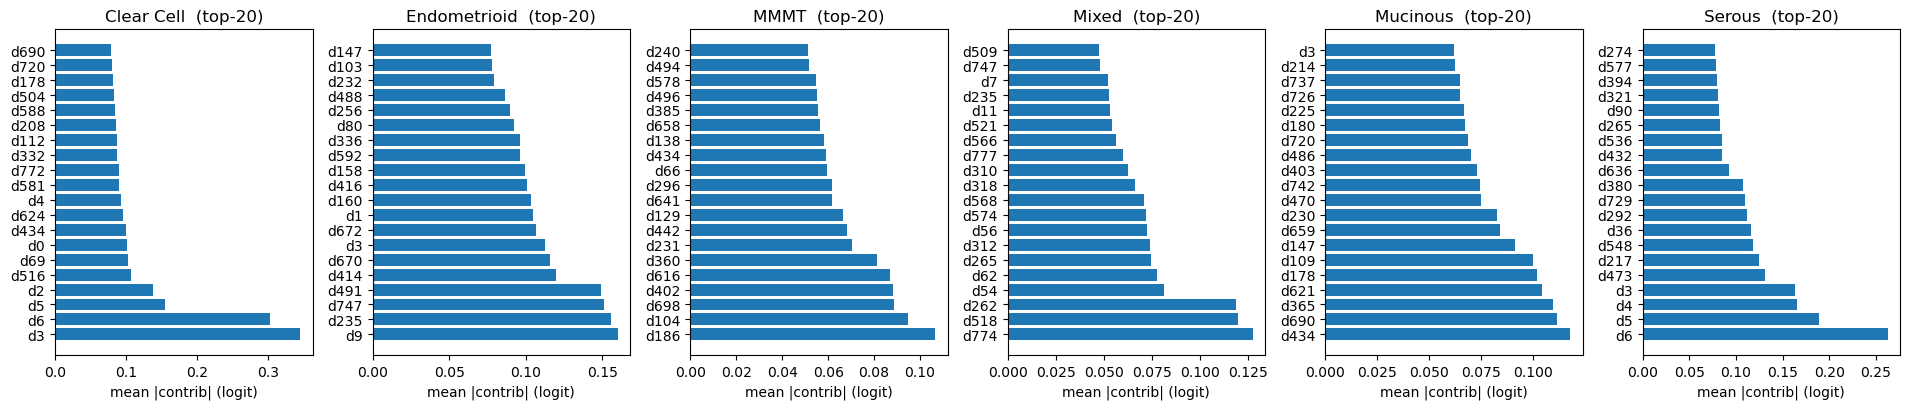

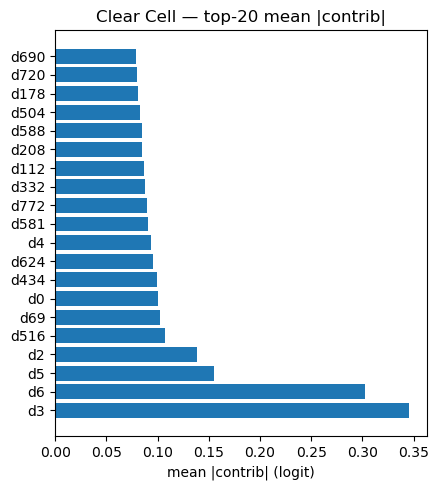

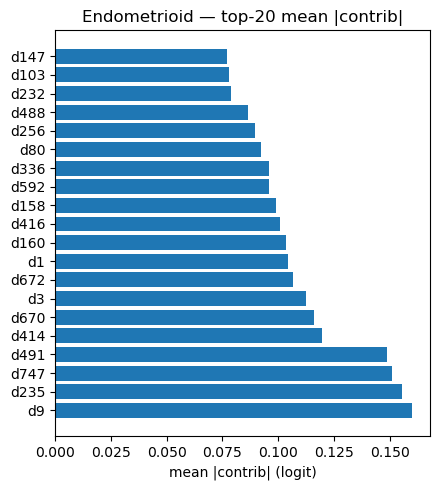

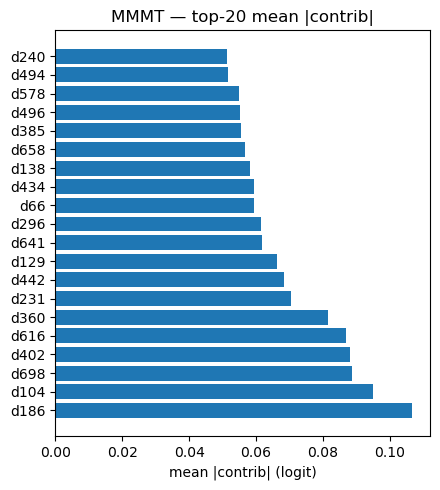

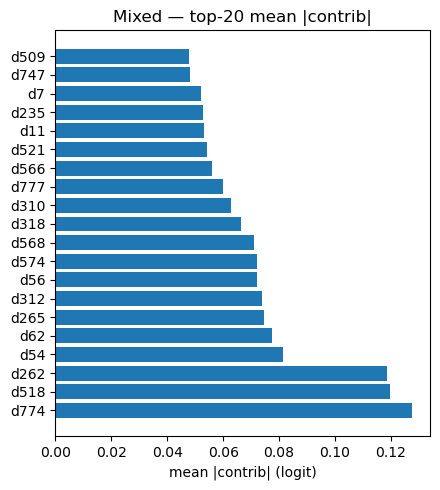

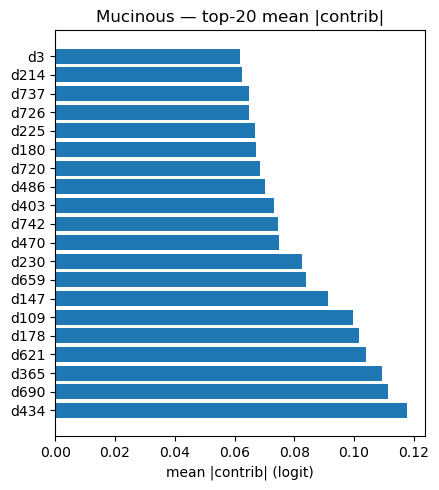

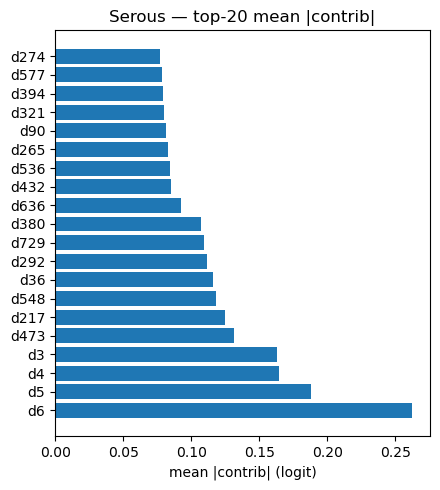

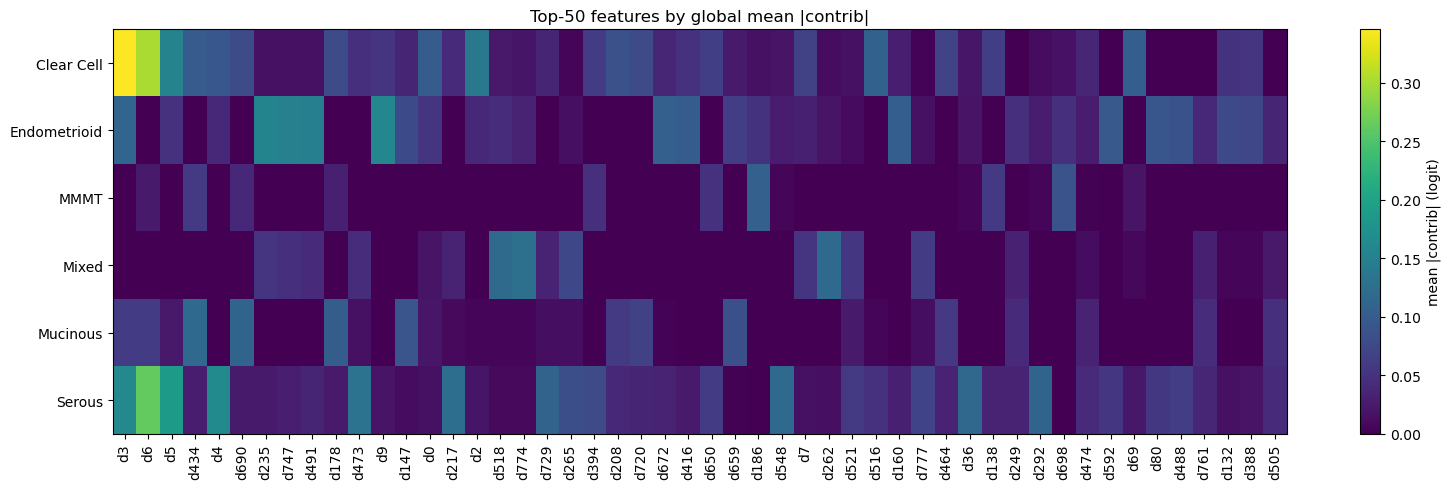

In [32]:
# --- Visualization for ROI-dimension attributions ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ATTR_DIR = EVAL_DIR / "attribution"
ATTR_DIR.mkdir(parents=True, exist_ok=True)

# Load long-form attributions
attr_csv = ATTR_DIR / "roi_dim_attributions_long.csv"
assert attr_csv.exists(), f"Missing {attr_csv}. Run the attribution block first."
attr_df = pd.read_csv(attr_csv)

# Parameters
k_top_bar   = 20   # top features per class for bar plots
topN_heat   = 50   # how many features to show in heatmap (by global mean |contrib|)
max_roi_fig = 50   # only render up to this many ROI waterfall plots (to avoid tons of files)
# --- Per-class top-k mean |contrib| bar chart ---
summ_class_feat = (attr_df
                   .groupby(["class","feat_idx"])["contrib"]
                   .apply(lambda s: float(np.mean(np.abs(s))))
                   .reset_index(name="mean_abs_contrib"))

classes = list(summ_class_feat["class"].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(3.2*len(classes), 4.2), squeeze=False)
axes = axes[0]
for ax, cls in zip(axes, classes):
    sub = summ_class_feat[summ_class_feat["class"] == cls]\
            .sort_values("mean_abs_contrib", ascending=False)\
            .head(k_top_bar)
    ax.barh([f"d{int(j)}" for j in sub["feat_idx"][::-1]], sub["mean_abs_contrib"][::-1].values)
    ax.set_title(f"{cls}  (top-{k_top_bar})")
    ax.set_xlabel("mean |contrib| (logit)")
    ax.invert_yaxis()
plt.tight_layout()
plt.savefig(ATTR_DIR / "bar_topk_mean_abs_by_class.png", dpi=160)  # fixed
plt.show()
plt.close()

# Also save per-class individual figures
for cls in classes:
    sub = summ_class_feat[summ_class_feat["class"] == cls]\
            .sort_values("mean_abs_contrib", ascending=False)\
            .head(k_top_bar)
    plt.figure(figsize=(4.5, 5.0))
    plt.barh([f"d{int(j)}" for j in sub["feat_idx"][::-1]], sub["mean_abs_contrib"][::-1].values)
    plt.title(f"{cls} — top-{k_top_bar} mean |contrib|")
    plt.xlabel("mean |contrib| (logit)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    plt.savefig(ATTR_DIR / f"bar_top{k_top_bar}_{cls}.png", dpi=160)
    plt.show()
    plt.close()

# --- Heatmap selection (this part didn’t reference 'class' in query, but keep it explicit) ---
global_feat_score = (summ_class_feat
                     .groupby("feat_idx")["mean_abs_contrib"]
                     .mean()
                     .sort_values(ascending=False)
                     .head(topN_heat))
top_feats = list(global_feat_score.index.astype(int))

heat_df = (summ_class_feat[summ_class_feat["feat_idx"].isin(top_feats)]
           .pivot_table(index="class", columns="feat_idx",
                        values="mean_abs_contrib", fill_value=0.0))
heat_df = heat_df.reindex(columns=top_feats)

plt.figure(figsize=(0.28*len(top_feats)+2.0, 0.5*len(classes)+2.0))
plt.imshow(heat_df.values, aspect='auto')
plt.yticks(ticks=np.arange(len(heat_df.index)), labels=heat_df.index)
plt.xticks(ticks=np.arange(len(heat_df.columns)), labels=[f"d{int(c)}" for c in heat_df.columns], rotation=90)
plt.colorbar(label="mean |contrib| (logit)")
plt.title(f"Top-{topN_heat} features by global mean |contrib|")
plt.tight_layout()
plt.savefig(ATTR_DIR / f"heatmap_top{topN_heat}_class_by_feature.png", dpi=160)
plt.show()
plt.close()

# --- Per-ROI waterfall (make the same 'class' fix in the filtering step) ---
roi_pred = (attr_df
            .sort_values(["ROI","class"])
            .merge(
                attr_df[["ROI","y_pred"]].drop_duplicates().rename(columns={"y_pred":"pred_class"}),
                on="ROI", how="left"
            ))
roi_pred = roi_pred[roi_pred["class"] == roi_pred["pred_class"]]


In [34]:
phenos = pd.get_dummies(df["phenotype"], prefix="ph", dtype=float) 
list(phenos.columns)


['ph_meta_1',
 'ph_meta_10',
 'ph_meta_2',
 'ph_meta_3',
 'ph_meta_4',
 'ph_meta_5',
 'ph_meta_6',
 'ph_meta_7',
 'ph_meta_8',
 'ph_meta_9']

,class,precision,recall,f1,support
0,Clear Cell,0.592593,0.695652,0.640000,23
1,Endometrioid,0.394366,0.777778,0.523364,36
2,MMMT,0.666667,0.666667,0.666667,3
3,Mixed,0.800000,0.666667,0.727273,6
4,Mucinous,0.666667,0.666667,0.666667,6
5,Serous,0.918033,0.760181,0.831683,221


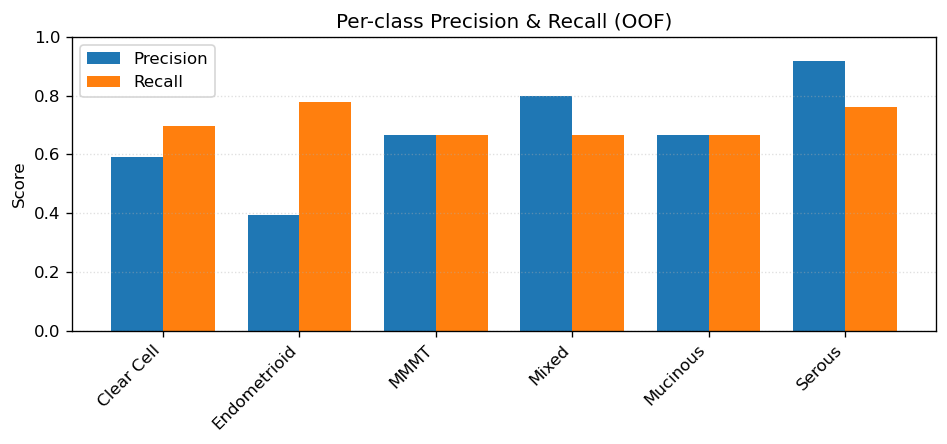

ValueError: If using all scalar values, you must pass an index

In [ ]:




# ---- 1) Overall (OOF) precision/recall in ONE plot ----
# Map string labels to indices per le.classes_ to align with training order
class_to_idx = {c:i for i,c in enumerate(le.classes_)}
y_true_idx = oof["y_true"].map(class_to_idx).values
y_pred_idx = oof["y_pred"].map(class_to_idx).values

overall_pr = pr_table(y_true_idx, y_pred_idx, class_names=le.classes_)
display(overall_pr[["class","precision","recall","f1","support"]])
plot_pr_grouped(overall_pr, title="Per-class Precision & Recall (OOF)", ylim=(0,1))

# ---- 2) Fold-by-fold precision/recall (one plot per fold) ----
for fold_id, g in oof.groupby("fold", sort=True):
    y_true_idx_f = g["y_true"].map(class_to_idx).values
    y_pred_idx_f = g["y_pred"].map(class_to_idx).values
    pr_f = pr_table(y_true_idx_f, y_pred_idx_f, class_names=le.classes_)
    display(pd.DataFrame({"fold": fold_id}).join(pr_f[["class","precision","recall","f1","support"]]))
    plot_pr_grouped(pr_f, title=f"Per-class Precision & Recall — Fold {fold_id}", ylim=(0,1))
